In [43]:
import yfinance as yf
import pandas as pd
import numpy as np
import random
from enum import Enum
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

In [44]:
def calculateRetrocesosDeFibonacci(data):
    # Parámetros para los Retrocesos de Fibonacci
    n = 20  # Número de períodos para calcular los niveles de retroceso de Fibonacci

    # Calcular los niveles de retroceso de Fibonacci para cada fila
    max_price = data['High'].rolling(window=n).max()
    min_price = data['Low'].rolling(window=n).min()
    difference = max_price - min_price

    data['Fibonacci_38.2'] = min_price + difference * 0.382
    data['Fibonacci_50'] = min_price + difference * 0.5
    data['Fibonacci_61.8'] = min_price + difference * 0.618

In [45]:
def calculateMediaMovil(data):
    # Parámetros para las medias móviles
    n = 14  # Número de períodos para calcular las medias móviles
    n_short = 5
    n_long = 20

    # Calcular la media móvil simple (SMA)
    data['SMA'] = data['Close'].rolling(window=n).mean()
    data['SMA_short'] = data['Close'].rolling(window=n_short).mean()
    data['SMA_long'] = data['Close'].rolling(window=n_long).mean()

    # Calcular la media móvil exponencial (EMA)
    data['EMA'] = data['Close'].ewm(span=n, adjust=False).mean()
    

In [46]:
def calculateRSI(data):
    # Parámetros para el RSI
    n = 14  # Número de períodos para calcular el RSI

    # Calcular la diferencia de precios
    delta = data['Close'].diff()

    # Calcular las ganancias y pérdidas
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calcular la media de las ganancias y pérdidas
    avg_gain = gain.rolling(window=n).mean()
    avg_loss = loss.rolling(window=n).mean()

    # Calcular el RS (Relative Strength)
    rs = avg_gain / avg_loss

    # Calcular el RSI (Relative Strength Index)
    data['RSI'] = 100 - (100 / (1 + rs))
    

In [47]:
def calculateRCI(data):
    # Parámetros para el RCI
    n = 14  # Número de períodos para calcular el RCI

    # Función para calcular el RCI
    def rci(close, n):
        sorted_prices = close.sort_values().rank()
        rank_diff = close.rank() - sorted_prices
        squared_rank_diff_sum = (rank_diff ** 2).sum()
        return (1 - (6 * squared_rank_diff_sum) / (n * (n ** 2 - 1))) * 100

    # Calcular el RCI
    data['RCI'] = data['Close'].rolling(window=n).apply(rci, args=(n,))
    

In [48]:
def calculateMomentum(data):
    # Parámetros para el Momentum
    n = 14  # Número de períodos para calcular la diferencia en los precios de cierre

    # Calcular el Momentum
    data['Momentum'] = data['Close'] - data['Close'].shift(n)
    

In [49]:
def calculateMACDandHistogram(data):
    # Parámetros para el MACD
    n1 = 12
    n2 = 26
    n3 = 9

    # Calcular el MACD
    ema_12 = data['Close'].ewm(span=n1, adjust=False).mean()
    ema_26 = data['Close'].ewm(span=n2, adjust=False).mean()
    data['MACD'] = ema_12 - ema_26
    data['Signal'] = data['MACD'].ewm(span=n3, adjust=False).mean()
    data['Histogram'] = data['MACD'] - data['Signal']
    

In [50]:
def calculateIchimoku(data):
    # Parámetros para el Ichimoku Kinko Hyo
    n1 = 9
    n2 = 26
    n3 = 52

    # Calcular el Ichimoku Kinko Hyo
    high_max_9 = data['High'].rolling(window=n1).max()
    low_min_9 = data['Low'].rolling(window=n1).min()
    data['Tenkan_sen'] = (high_max_9 + low_min_9) / 2

    high_max_26 = data['High'].rolling(window=n2).max()
    low_min_26 = data['Low'].rolling(window=n2).min()
    data['Kijun_sen'] = (high_max_26 + low_min_26) / 2

    data['Senkou_Span_A'] = ((data['Tenkan_sen'] + data['Kijun_sen']) / 2).shift(n2)
    data['Senkou_Span_B'] = ((data['High'].rolling(window=n3).max() + data['Low'].rolling(window=n3).min()) / 2).shift(n2)

    #data['Chikou_Span'] = data['Close'].shift(-n2)
    

In [51]:
def calculateEstocástico(data):
    # Parámetros para el Oscilador Estocástico
    n = 14  # Número de períodos para calcular los máximos y mínimos
    m = 3   # Número de períodos para calcular la media móvil de %K

    # Calcular el Oscilador Estocástico
    highest_high = data['High'].rolling(window=n).max()
    lowest_low = data['Low'].rolling(window=n).min()
    data['Stochastic_K'] = (data['Close'] - lowest_low) / (highest_high - lowest_low) * 100
    data['Stochastic_D'] = data['Stochastic_K'].rolling(window=m).mean()
    

In [52]:
def calculateCanalDeDonchain(data):
    # Parámetros para el Canal de Donchian
    n = 20  # Número de períodos para calcular los máximos y mínimos

    # Calcular el Canal de Donchian
    data['Upper_Channel'] = data['High'].rolling(window=n).max()
    data['Lower_Channel'] = data['Low'].rolling(window=n).min()
    data['Center_Channel'] = (data['Upper_Channel'] + data['Lower_Channel']) / 2
    

In [53]:
def calculateBandasDeBollinger(data):
    # Parámetros para las Bandas de Bollinger
    n = 20  # Número de períodos para la media móvil y la desviación estándar
    k = 2  # Factor multiplicador para el ancho de las bandas

    # Calcular las Bandas de Bollinger
    sma = data['Close'].rolling(window=n).mean()
    std_dev = data['Close'].rolling(window=n).std()
    data['Upper_Band'] = sma + (std_dev * k)
    data['Lower_Band'] = sma - (std_dev * k)

In [54]:
def downloadIndicators(symbol, start_date, end_date, frecuency, T):

    data = yf.download(symbol, start=start_date, end=end_date)

    calculateBandasDeBollinger(data)
    calculateCanalDeDonchain(data)
    calculateEstocástico(data)
    calculateIchimoku(data)
    calculateMACDandHistogram(data)
    calculateMediaMovil(data)
    calculateMomentum(data)
    calculateRCI(data)
    calculateRSI(data)
    calculateRetrocesosDeFibonacci(data)
    # El indicador Volumen no hace falta calcularlo porque ya viene incluido cuando descargas los datos de yahoo

    # Eliminar las filas con algun campo NaN
    data_clean = data.dropna()

    # Cambiar la frecuencia de los datos a cada X días
    frecuency += 'D'
    data_resampled = data_clean.resample(frecuency).last()

    # Selecciona las primeras 'T' filas
    data_resampled = data_resampled.iloc[:T+1]

    return data_resampled

In [55]:
class Position(Enum):
    LONG = 'long'
    HOLD = 'hold'
    SHORT = 'short'

In [56]:
class AllIndicatorsExpert:
    def __init__(self, num_arms):
        self.probabilities = np.zeros(num_arms)  # probabilidades de elección de cada brazo
        self.name = "Experto en Todo"
        self.last_decision = Position.SHORT

    def select_arm(self, indicadores, actualPosition):
        close_price = indicadores['Close']
        upper_band = indicadores['Upper_Band']
        lower_band = indicadores['Lower_Band']
        high_max = indicadores['Upper_Channel']
        low_min = indicadores['Lower_Channel']
        stoch_k = indicadores['Stochastic_K']
        stoch_d = indicadores['Stochastic_D']
        ichimoku_conversion = indicadores['Tenkan_sen']
        ichimoku_base = indicadores['Kijun_sen']
        macd = indicadores['MACD']
        macd_signal = indicadores['Signal']
        momentum = indicadores['Momentum']
        rci = indicadores['RCI']
        rsi = indicadores['RSI']
        volume = indicadores['Volume']
        sma = indicadores['SMA']
        fib_38 = indicadores['Fibonacci_38.2']
        fib_50 = indicadores['Fibonacci_50']
        fib_61 = indicadores['Fibonacci_61.8']

        conditions = [
            close_price > upper_band,
            close_price < lower_band,
            close_price > high_max,
            close_price < low_min,
            stoch_k > stoch_d,
            ichimoku_conversion > ichimoku_base,
            macd > macd_signal,
            momentum > 0,
            rci > 0,
            rsi > 50,
            volume > sma,
            close_price > fib_61
        ]

        num_true_conditions = sum(conditions)

        if actualPosition == Position.LONG:  # Si actualmente posee la acción
            if num_true_conditions >= 6:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0, 0.9, 0.1])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.SHORT
                self.probabilities = np.array([0, 0.1, 0.9])  # Probabilidades de long, hold, short
        else:  # Si no posee la acción actualmente
            if num_true_conditions >= 6:
                nextPosition = Position.LONG
                self.probabilities = np.array([0.9, 0.1, 0])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0.1, 0.9, 0])  # Probabilidades de long, hold, short

        self.last_decision = nextPosition

        return nextPosition

    def get_arm_probability(self, arm):  # Se llama desde el EXP4
        return self.probabilities[arm]

    def get_name(self):
        return self.name

    def get_last_decision(self):
        return self.last_decision

In [57]:
class MacdRsiExpert:
    def __init__(self, num_arms):
        self.probabilities = np.zeros(num_arms)
        self.name = "MacdRsiExpert"
        self.last_decision = Position.SHORT

    def select_arm(self, indicadores, actualPosition):
        macd_histogram = indicadores['Histogram']
        rsi = indicadores['RSI']

        if actualPosition == Position.LONG: # Si actualmente posee la acción
            if rsi < 30 or macd_histogram > 0:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0, 0.9, 0.1])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.SHORT
                self.probabilities = np.array([0, 0.1, 0.9])  # Probabilidades de long, hold, short

        else: # Si no posee la acción actualmente
            if rsi > 70 or macd_histogram < 0:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0.1, 0.9, 0])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.LONG
                self.probabilities = np.array([0.9, 0.1, 0])  # Probabilidades de long, hold, short

        self.last_decision = nextPosition

        return nextPosition

    def get_arm_probability(self, arm):
        return self.probabilities[arm]

    def get_name(self):
        return self.name

    def get_last_decision(self):
        return self.last_decision

In [58]:
class FibonacciExpert:
    def __init__(self, num_arms):
        self.probabilities = np.zeros(num_arms)  # probabilidades de elección de cada brazo
        self.name = "Experto en Fibonacci"
        self.last_decision = Position.SHORT

    def select_arm(self, indicadores, actualPosition):
        close_price = indicadores['Close']
        fib_38 = indicadores['Fibonacci_38.2']
        fib_50 = indicadores['Fibonacci_50']
        fib_61 = indicadores['Fibonacci_61.8']

        if actualPosition == Position.LONG:  # Si actualmente posee la acción
            if close_price < fib_38:
                nextPosition = Position.SHORT
                self.probabilities = np.array([0, 0.1, 0.9])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0, 0.9, 0.1])  # Probabilidades de long, hold, short
        else:  # Si no posee la acción actualmente
            if close_price > fib_61:
                nextPosition = Position.LONG
                self.probabilities = np.array([0.9, 0.1, 0])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0.1, 0.9, 0])  # Probabilidades de long, hold, short

        self.last_decision = nextPosition

        return nextPosition

    def get_arm_probability(self, arm):  # Se llama desde el EXP4
        return self.probabilities[arm]

    def get_name(self):
        return self.name

    def get_last_decision(self):
        return self.last_decision

In [59]:
class IchimokuExpert:
    def __init__(self, num_arms):
        self.probabilities = np.zeros(num_arms)  # probabilidades de elección de cada brazo
        self.name = "Experto en Ichimoku"
        self.last_decision = Position.SHORT

    def select_arm(self, indicadores, actualPosition):
        close_price = indicadores['Close']
        tenkan_sen = indicadores['Tenkan_sen']
        kijun_sen = indicadores['Kijun_sen']
        senkou_span_a = indicadores['Senkou_Span_A']
        senkou_span_b = indicadores['Senkou_Span_B']

        if actualPosition == Position.LONG:  # Si actualmente posee la acción
            if close_price < kijun_sen and close_price < senkou_span_a and close_price < senkou_span_b:
                nextPosition = Position.SHORT
                self.probabilities = np.array([0, 0.1, 0.9])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0, 0.9, 0.1])  # Probabilidades de long, hold, short
        else:  # Si no posee la acción actualmente
            if close_price > kijun_sen and close_price > senkou_span_a and close_price > senkou_span_b:
                nextPosition = Position.LONG
                self.probabilities = np.array([0.9, 0.1, 0])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0.1, 0.9, 0])  # Probabilidades de long, hold, short

        self.last_decision = nextPosition
        
        return nextPosition

    def get_arm_probability(self, arm):  # Se llama desde el EXP4
        return self.probabilities[arm]

    def get_name(self):
        return self.name

    def get_last_decision(self):
        return self.last_decision

In [60]:
class FocusedExpert:
    def __init__(self, num_arms):
        self.probabilities = np.zeros(num_arms)  # probabilidades de elección de cada brazo
        self.name = "FocusedExpert"
        self.last_decision = Position.SHORT

    def select_arm(self, indicadores, actualPosition):
        rsi = indicadores['RSI']
        close_price = indicadores['Close']
        upper_band = indicadores['Upper_Band']
        lower_band = indicadores['Lower_Band']
        high_max = indicadores['Upper_Channel']
        low_min = indicadores['Lower_Channel']

        rsi_oversold = 30
        rsi_overbought = 70

        if actualPosition == Position.LONG:  # Si actualmente posee la acción
            if (rsi > rsi_overbought) and (close_price > upper_band) and (close_price < high_max):
                nextPosition = Position.SHORT
                self.probabilities = np.array([0, 0.1, 0.9])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0, 0.9, 0.1])  # Probabilidades de long, hold, short
        else:  # Si no posee la acción actualmente
            if (rsi < rsi_oversold) and (close_price < lower_band) and (close_price > low_min):
                nextPosition = Position.LONG
                self.probabilities = np.array([0.9, 0.1, 0])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0.1, 0.9, 0])  # Probabilidades de long, hold, short

        self.last_decision = nextPosition
        
        return nextPosition

    def get_arm_probability(self, arm):  # Se llama desde el EXP4
        return self.probabilities[arm]

    def get_name(self):
        return self.name

    def get_last_decision(self):
        return self.last_decision

In [61]:
class CustomExpert:
    def __init__(self, num_arms):
        self.probabilities = np.zeros(num_arms)  # probabilidades de elección de cada brazo
        self.name = "CustomExpert"
        self.last_decision = Position.SHORT

    def select_arm(self, indicadores, actualPosition):
        rsi = indicadores['RSI']
        macd_line = indicadores['MACD']
        macd_signal = indicadores['Signal']
        momentum = indicadores['Momentum']
        sma = indicadores['SMA']
        close_price = indicadores['Close']
        high_max = indicadores['Upper_Channel']
        low_min = indicadores['Lower_Channel']

        rsi_oversold = 30
        rsi_overbought = 70

        if actualPosition == Position.LONG:  # Si actualmente posee la acción
            if (rsi > rsi_overbought) and (macd_line < macd_signal) and (momentum < 0) and (close_price > sma):
                nextPosition = Position.SHORT
                self.probabilities = np.array([0, 0.1, 0.9])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0, 0.9, 0.1])  # Probabilidades de long, hold, short
        else:  # Si no posee la acción actualmente
            if (rsi < rsi_oversold) and (macd_line > macd_signal) and (momentum > 0) and (close_price < sma) and (close_price > low_min):
                nextPosition = Position.LONG
                self.probabilities = np.array([0.9, 0.1, 0])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0.1, 0.9, 0])  # Probabilidades de long, hold, short

        self.last_decision = nextPosition
        
        return nextPosition

    def get_arm_probability(self, arm):  # Se llama desde el EXP4
        return self.probabilities[arm]

    def get_name(self):
        return self.name

    def get_last_decision(self):
        return self.last_decision

In [62]:
class MultiIndicatorExpert:
    def __init__(self, num_arms):
        self.probabilities = np.zeros(num_arms)  # probabilidades de elección de cada brazo
        self.name = "MultiIndicatorExpert"
        self.last_decision = Position.SHORT

    def select_arm(self, indicadores, actualPosition):
        rsi = indicadores['RSI']
        macd_line = indicadores['MACD']
        macd_signal = indicadores['Signal']
        upper_band = indicadores['Upper_Band']
        lower_band = indicadores['Lower_Band']
        close_price = indicadores['Close']

        rsi_oversold = 30
        rsi_overbought = 70

        if actualPosition == Position.LONG:  # Si actualmente posee la acción
            if (rsi > rsi_overbought) and (macd_line < macd_signal) and (close_price > upper_band):
                nextPosition = Position.SHORT
                self.probabilities = np.array([0, 0.1, 0.9])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0, 0.9, 0.1])  # Probabilidades de long, hold, short
        else:  # Si no posee la acción actualmente
            if (rsi < rsi_oversold) and (macd_line > macd_signal) and (close_price < lower_band):
                nextPosition = Position.LONG
                self.probabilities = np.array([0.9, 0.1, 0])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0.1, 0.9, 0])  # Probabilidades de long, hold, short

        self.last_decision = nextPosition
        
        return nextPosition

    def get_arm_probability(self, arm):  # Se llama desde el EXP4
        return self.probabilities[arm]

    def get_name(self):
        return self.name

    def get_last_decision(self):
        return self.last_decision

In [63]:
class MovingAverageCrossoverExpert:
    def __init__(self, num_arms):
        self.probabilities = np.zeros(num_arms)  # probabilidades de elección de cada brazo
        self.name = "Experto en Cruce de Medias Móviles"
        self.last_decision = Position.SHORT

    def select_arm(self, indicadores, actualPosition):
        sma_short = indicadores['SMA_short']
        sma_long = indicadores['SMA_long']

        if actualPosition == Position.LONG:  # Si actualmente posee la acción
            if sma_short < sma_long:  # Condiciones de venta (la media móvil corta cruza hacia abajo la media móvil larga)
                nextPosition = Position.SHORT
                self.probabilities = np.array([0, 0.1, 0.9])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0, 0.9, 0.1])  # Probabilidades de long, hold, short
        else:  # Si no posee la acción actualmente
            if sma_short > sma_long:  # Condiciones de compra (la media móvil corta cruza hacia arriba la media móvil larga)
                nextPosition = Position.LONG
                self.probabilities = np.array([0.9, 0.1, 0])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0.1, 0.9, 0])  # Probabilidades de long, hold, short

        self.last_decision = nextPosition
        
        return nextPosition

    def get_arm_probability(self, arm):  # Se llama desde el EXP4
        return self.probabilities[arm]

    def get_name(self):
        return self.name

    def get_last_decision(self):
        return self.last_decision

In [64]:
class MACDBollingerExpert:
    def __init__(self, num_arms):
        self.probabilities = np.zeros(num_arms)  # probabilidades de elección de cada brazo
        self.name = "Experto en MACD y Bandas de Bollinger"
        self.last_decision = Position.SHORT

    def select_arm(self, indicadores, actualPosition):
        macd = indicadores['MACD']
        macd_signal = indicadores['Signal']
        upper_band = indicadores['Upper_Band']
        lower_band = indicadores['Lower_Band']
        close = indicadores['Close']

        if actualPosition == Position.LONG:  # Si actualmente posee la acción
            if macd < macd_signal or close > upper_band:  # Condiciones de venta (MACD cruza hacia abajo o el precio está por encima de la banda superior)
                nextPosition = Position.SHORT
                self.probabilities = np.array([0, 0.1, 0.9])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0, 0.9, 0.1])  # Probabilidades de long, hold, short
        else:  # Si no posee la acción actualmente
            if macd > macd_signal or close < lower_band:  # Condiciones de compra (MACD cruza hacia arriba o el precio está por debajo de la banda inferior)
                nextPosition = Position.LONG
                self.probabilities = np.array([0.9, 0.1, 0])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0.1, 0.9, 0])  # Probabilidades de long, hold, short

        self.last_decision = nextPosition
        
        return nextPosition

    def get_arm_probability(self, arm):  # Se llama desde el EXP4
        return self.probabilities[arm]

    def get_name(self):
        return self.name

    def get_last_decision(self):
        return self.last_decision

In [65]:
class RSIDonchianExpert:
    def __init__(self, num_arms):
        self.probabilities = np.zeros(num_arms)  # probabilidades de elección de cada brazo
        self.name = "RSIDonchianExpert"
        self.last_decision = Position.SHORT

    def select_arm(self, indicadores, actualPosition):
        rsi = indicadores['RSI']
        high_max = indicadores['Upper_Channel']
        low_min = indicadores['Lower_Channel']
        close = indicadores['Close']

        if actualPosition == Position.LONG:  # Si actualmente posee la acción
            if rsi > 70 or close < low_min:  # Condiciones de venta (RSI sobrecomprado o rompiendo el soporte)
                nextPosition = Position.SHORT
                self.probabilities = np.array([0, 0.1, 0.9])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0, 0.9, 0.1])  # Probabilidades de long, hold, short
        else:  # Si no posee la acción actualmente
            if rsi < 30 or close > high_max:  # Condiciones de compra (RSI sobrevendido o rompiendo la resistencia)
                nextPosition = Position.LONG
                self.probabilities = np.array([0.9, 0.1, 0])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0.1, 0.9, 0])  # Probabilidades de long, hold, short

        self.last_decision = nextPosition
        
        return nextPosition

    def get_arm_probability(self, arm):  # Se llama desde el EXP4
        return self.probabilities[arm]

    def get_name(self):
        return self.name

    def get_last_decision(self):
        return self.last_decision

In [66]:
class RSIExpert:
    def __init__(self, num_arms):
        self.probabilities = np.zeros(num_arms)  # probabilidades de elección de cada brazo
        self.name = "Experto en RSI"
        self.last_decision = Position.SHORT # Su valor será modificado desde la primera ronda

    def select_arm(self, indicadores, actualPosition):
        rsi = indicadores['RSI']
        rsi_oversold = 30  # Umbral de sobreventa, puedes ajustarlo según tus preferencias
        rsi_overbought = 70  # Umbral de sobrecompra, puedes ajustarlo según tus preferencias

        if actualPosition == Position.LONG:  # Si actualmente posee la acción
            if rsi > rsi_overbought:  # Condiciones de venta (RSI supera el umbral de sobrecompra)
                nextPosition = Position.SHORT
                self.probabilities = np.array([0, 0.1, 0.9])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0, 0.9, 0.1])  # Probabilidades de long, hold, short
        else:  # Si no posee la acción actualmente
            if rsi < rsi_oversold:  # Condiciones de compra (RSI está por debajo del umbral de sobreventa)
                nextPosition = Position.LONG
                self.probabilities = np.array([0.9, 0.1, 0])  # Probabilidades de long, hold, short
            else:
                nextPosition = Position.HOLD
                self.probabilities = np.array([0.1, 0.9, 0])  # Probabilidades de long, hold, short

        self.last_decision = nextPosition
        
        return nextPosition

    def get_arm_probability(self, arm):  # Se llama desde el EXP4
        return self.probabilities[arm]

    def get_name(self):
        return self.name
      
    def get_last_decision(self):
        return self.last_decision

In [67]:
class AlwaysLongExpert:
    def __init__(self, num_arms):
        self.probabilities = np.zeros(num_arms)  # probabilidades de elección de cada brazo
        self.name = "Experto en Posiciones Largas"
        self.last_decision = Position.SHORT # Su valor será modificado desde la primera ronda

    def select_arm(self, indicadores, actualPosition):

        if actualPosition == Position.SHORT:  # Si no posee actualmente la acción
            nextPosition = Position.LONG
            self.probabilities = np.array([0.9, 0.1, 0])  # Probabilidades de long, hold, short
        else:  # Si posee la acción actualmente
            nextPosition = Position.HOLD
            self.probabilities = np.array([0, 0.9, 0.1])  # Probabilidades de long, hold, short

        self.last_decision = nextPosition
        
        return nextPosition

    def get_arm_probability(self, arm):  # Se llama desde el EXP4
        return self.probabilities[arm]

    def get_name(self):
        return self.name
      
    def get_last_decision(self):
        return self.last_decision

In [68]:
class AlwaysShortExpert:
    def __init__(self, num_arms):
        self.probabilities = np.zeros(num_arms)  # probabilidades de elección de cada brazo
        self.name = "Experto en Posiciones Cortas"
        self.last_decision = Position.SHORT # Su valor será modificado desde la primera ronda

    def select_arm(self, indicadores, actualPosition):

        if actualPosition == Position.SHORT:  # Si no posee actualmente la acción
            nextPosition = Position.HOLD
            self.probabilities = np.array([0.1, 0.9, 0])  # Probabilidades de long, hold, short
        else:  # Si posee la acción actualmente
            nextPosition = Position.SHORT
            self.probabilities = np.array([0, 0.1, 0.9])  # Probabilidades de long, hold, short

        self.last_decision = nextPosition
        
        return nextPosition

    def get_arm_probability(self, arm):  # Se llama desde el EXP4
        return self.probabilities[arm]

    def get_name(self):
        return self.name
      
    def get_last_decision(self):
        return self.last_decision

In [69]:
class AlwaysChangingExpert:
    def __init__(self, num_arms):
        self.probabilities = np.zeros(num_arms)  # probabilidades de elección de cada brazo
        self.name = "Experto en Posiciones Cambiantes"
        self.last_decision = Position.SHORT # Su valor será modificado desde la primera ronda

    def select_arm(self, indicadores, actualPosition):

        if actualPosition == Position.SHORT:  # Si no posee actualmente la acción
            nextPosition = Position.LONG
            self.probabilities = np.array([0.9, 0.1, 0])  # Probabilidades de long, hold, short
        else:  # Si posee la acción actualmente
            nextPosition = Position.SHORT
            self.probabilities = np.array([0, 0.1, 0.9])  # Probabilidades de long, hold, short

        self.last_decision = nextPosition
        
        return nextPosition

    def get_arm_probability(self, arm):  # Se llama desde el EXP4
        return self.probabilities[arm]

    def get_name(self):
        return self.name
      
    def get_last_decision(self):
        return self.last_decision

In [70]:
def createExperts(numArms):

    experts = []
    experts.append(AlwaysShortExpert(numArms))
    experts.append(AlwaysLongExpert(numArms))
    experts.append(AlwaysChangingExpert(numArms))    
    experts.append(MovingAverageCrossoverExpert(numArms))
    experts.append(RSIExpert(numArms))
    experts.append(MACDBollingerExpert(numArms))
    experts.append(AllIndicatorsExpert(numArms))

    #experts.append(IchimokuExpert(numArms))
    #experts.append(FibonacciExpert(numArms))
    #experts.append(RSIDonchianExpert(numArms))
    #experts.append(MultiIndicatorExpert(numArms))
    #experts.append(CustomExpert(numArms))
    #experts.append(FocusedExpert(numArms))    
    #experts.append(MacdRsiExpert(numArms))
    
    return experts

In [71]:
class Hedge:
    def __init__(self, num_experts, eta):
        self.num_experts = num_experts
        self.eta = eta
        self.weights = np.ones(num_experts)
        self.probabilities = self.weights / np.sum(self.weights)

    def update_weights(self, costs):
        for e in range(self.num_experts):
            self.weights[e] *= (1 - self.eta) ** costs[e]
        
        min_weight = np.min(self.weights)
        if min_weight < 1e-50:
            self.weights = self.weights / min_weight 

        self.weights = np.where(np.isnan(self.weights), 1e-1, self.weights)
        self.weights = np.where(np.isinf(self.weights), 1e+250, self.weights)

        self.probabilities = self.weights / (np.sum(self.weights)+ 1e-10) 
      
        num_nan_values = np.count_nonzero(np.isnan(self.probabilities))
        if num_nan_values > 0:
          non_nan_prob_sum = np.sum(self.probabilities[~np.isnan(self.probabilities)])
          correction = (1 - non_nan_prob_sum) / num_nan_values
          self.probabilities = np.where(np.isnan(self.probabilities), 0.0001, self.probabilities + correction)

        self.probabilities = self.probabilities / (np.sum(self.probabilities))

    def get_probabilities(self):
      return self.probabilities

    def get_weights(self):
      return self.weights

In [72]:
class Exp4:
    def __init__(self, eta, gamma, experts, postion_index):
        self.experts = experts
        self.num_experts = len(experts)
        self.chosenArms = [None] * len(experts)
        self.hedge = Hedge(self.num_experts, eta)
        self.gamma = gamma
        self.position_index = postion_index

    def sampleExpert(self, actualPosition):
        et = np.random.choice(self.num_experts, p=self.hedge.get_probabilities())

        if np.random.random() < (1 - self.gamma):
            at = self.chosenArms[et]
        else:
            if actualPosition == Position.LONG:
                at = random.choice([Position.SHORT, Position.HOLD])
            else: # actualPosition == Position.SHORT
                at = random.choice([Position.LONG, Position.HOLD])
        return at, et

    def executeExperts(self, indicadores, actualPosition):
        for e in range (self.num_experts):
            self.chosenArms[e] = self.experts[e].select_arm(indicadores, actualPosition)

    def update(self, reward, at):
        cost = 1 - reward 
        fake_costs = np.zeros(self.num_experts) 
        pt = 0  
        for e in range(self.num_experts):
            pt += self.experts[e].get_arm_probability(self.position_index[at]) * self.hedge.get_probabilities()[e]

        for e in range(self.num_experts):
            if at == self.chosenArms[e]:
              fake_costs[e] = cost / (pt)
        self.hedge.update_weights(fake_costs)

    def get_weights(self):
        return self.hedge.get_probabilities()

In [73]:
def reward_function(decision, current_price, future_price, actualPosition):
    price_difference = future_price - current_price

    if decision == Position.LONG:
        reward = 0.9 if price_difference > 0 else 0.1
    elif decision == Position.SHORT:
        reward = 0.9 if price_difference < 0 else 0.1
    else:  # decision == Position.HOLD
        if actualPosition == Position.LONG:
            reward = 0.9 if price_difference > 0 else 0.1
        else: # actualPosition == Position.SHORT
            reward = 0.9 if price_difference < 0 else 0.1

    return reward

In [33]:
def update_position(actualPosition, expert_decision):
    if expert_decision == Position.HOLD:
        return actualPosition
    elif expert_decision == Position.LONG:
        if actualPosition == Position.SHORT:
            return Position.LONG
        else:
            return actualPosition
    elif expert_decision == Position.SHORT:
        if actualPosition == Position.LONG:
            return Position.SHORT
        else:
            return actualPosition

In [34]:
def run_simulation(T, data, experts, postion_index, eta, gamma):
    exp4 = Exp4(eta, gamma, experts, postion_index)
    
    
    weights_history = []
    rewards = [] 
    experts_chosen_times = np.zeros((T, len(experts))) # Recuento de cuantas veces se elige cada experto
    average_rewards = np.zeros((T, len(experts))) # Evolución de las recompensas medias de cada experto en cada ronda. Solo reciben recompensa si son elegidos
    average_expected_rewards = np.zeros((T, len(experts))) # Evolución de las recompensas medias de cada experto en cada ronda simulando que todos los expertos siempre son elegidos
    precio = np.zeros(T) # Evolución del precio del titulo

    # Inicia la simulación con posicionInicial en 'short' --> Lo que quiere decir que al principio el algoritmo no posee acciones y por tanto, en la primera ronda solo puede comprar o mantenerse
    actualPosition = Position.SHORT     

    for i in range(T):
      indicadores = data.iloc[i]
      precio[i] = data.iloc[i]["Open"]

      exp4.executeExperts(indicadores, actualPosition) # Todos los expertos toman su decisión
      expert_decision, chosen_expert = exp4.sampleExpert(actualPosition) # El brazo elegido en la ronda i, y el experto que ha elegido dicho brazo
      experts_chosen_times[i, chosen_expert] += 1

      #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
      
      # PARA LAS CONLCUSIONES, NO FORMA PARTE DEL ALGORITMO EXP4

      # Solo para ver cuál sería la recompensa media de cada experto si fuese elegido siempre --> Esto nos demuestra quién es mejor y así podemos comprobar si el algoritmo aprende quién es el mejor de todos los expertos

      for expert in range(len(experts)):
        expected_expert_reward = reward_function(experts[expert].get_last_decision(), data.iloc[i]['Open'], data.iloc[i+1]['Open'], actualPosition)
        if i == 0:
          average_expected_rewards[i, expert] = expected_expert_reward
        else:
          average_expected_rewards[i, expert] = (average_expected_rewards[i - 1, expert] * i + expected_expert_reward) / (i + 1)

      #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

      reward = reward_function(expert_decision, data.iloc[i]['Open'], data.iloc[i+1]['Open'], actualPosition)

      #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
      
      # PARA LAS CONLCUSIONES, NO FORMA PARTE DEL ALGORITMO EXP4
      
      # Como Exp4 asigna los mismos costes falsos a todos aquellos expertos que toman la decision que finalmente ha sido la escogida por el algoritmo, en average rewards vamos a llevar la contabilidad de la recompensa media
      # de cada experto como si tuviesemos la perspectiva del exp4

      for expert in range(len(experts)):
        if i == 0:
          if experts[expert].get_last_decision() == expert_decision:
            average_rewards[i, expert] = reward
        else:
          if experts[expert].get_last_decision() == expert_decision:
            average_rewards[i, expert] = (average_rewards[i - 1, expert] * i + reward) / (i + 1)

      #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

      actualPosition = update_position(actualPosition, expert_decision)

      exp4.update(reward, expert_decision)

      weights_history.append(exp4.get_weights())
      rewards.append(reward)

    return rewards, weights_history, experts_chosen_times, average_rewards, average_expected_rewards, precio

In [35]:
def plot_weights_with_leyend(experts, weights_history, fechas):
    fig, ax = plt.subplots()
    for i in range(len(experts)):
        ax.plot(fechas, np.array(weights_history)[:, i], label=f"{experts[i].get_name()}")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Pesos de los Expertos")
    ax.set_title("Evolución de los Pesos de los Expertos")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
    fig.autofmt_xdate()  
    plt.show()

def plot_expert_chosen_times_with_leyend(experts, experts_chosen_times, fechas):
    fig, ax = plt.subplots()
    for i in range(len(experts)):
        ax.plot(fechas, np.cumsum(experts_chosen_times[:, i]), label=f"{experts[i].get_name()}")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Veces Elegido")
    ax.set_title("Número de veces que cada experto ha sido elegido")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
    fig.autofmt_xdate()  
    plt.show()

def plot_expert_mean_rewards_with_leyend(experts, average_rewards, fechas):
    fig, ax = plt.subplots()
    for i in range(len(experts)):
        ax.plot(fechas, average_rewards[:, i], label=f"{experts[i].get_name()}")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Recompensa Media")
    ax.set_title("Evolución de la Recompensa Media de Cada Experto")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
    fig.autofmt_xdate()  
    plt.show()

def plot_expert_expected_mean_rewards_with_leyend(experts, average_expected_rewards, fechas):
    fig, ax = plt.subplots()
    for i in range(len(experts)):
        ax.plot(fechas, average_expected_rewards[:, i], label=f"{experts[i].get_name()}")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Recompensa Media Esperada")
    ax.set_title("Evolución de la Recompensas Media Esperada de Cada Experto")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
    fig.autofmt_xdate()  
    plt.show()

In [36]:
def plot_precio (precio, symbol, fechas):
    fig, ax = plt.subplots(figsize=(10,5), dpi=100)
    ax.plot(fechas, precio, label=f"Precio del título {symbol}", color='red')
    ax.legend()
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Precio')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
    fig.autofmt_xdate() 
    plt.show()

def plot_algorithm_mean_rewards(rewards, fechas):
    fig, ax = plt.subplots(figsize=(10,5), dpi=100)
    avg_rewards = np.cumsum(rewards) / np.arange(1, len(rewards) + 1)
    ax.plot(fechas, avg_rewards, label='Evolución de la Recompensa Media', color='blue')
    ax.legend()
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Recompensa Media')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
    fig.autofmt_xdate()  
    plt.show()

def plot_legend(experts):
    fig = plt.figure()
    for i in range(len(experts)):
        plt.plot([], [], label=f"{experts[i].get_name()}")
    plt.legend(loc='center', prop={'size': 16})
    plt.axis('off')  
    fig.tight_layout()
    plt.show()

def plot_weights(experts, weights_history, fechas):
    fig, ax = plt.subplots()
    for i in range(len(experts)):
        ax.plot(fechas, np.array(weights_history)[:, i])
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Pesos de los Expertos")
    ax.set_title("Evolución de los Pesos de los Expertos")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
    fig.autofmt_xdate()  
    plt.show()


def plot_expert_chosen_times(experts, experts_chosen_times, fechas):
    fig, ax = plt.subplots()
    for i in range(len(experts)):
        ax.plot(fechas, np.cumsum(experts_chosen_times[:, i]))
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Veces Elegido")
    ax.set_title("Número de veces que cada experto ha sido elegido")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
    fig.autofmt_xdate()  
    plt.show()

def plot_expert_mean_rewards(experts, average_rewards, fechas):
    fig, ax = plt.subplots()
    for i in range(len(experts)):
        ax.plot(fechas, average_rewards[:, i])
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Recompensa Media")
    ax.set_title("Evolución de la Recompensa Media de Cada Experto")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
    fig.autofmt_xdate()  
    plt.show()
    
def plot_expert_expected_mean_rewards(experts, average_expected_rewards, fechas):
    fig, ax = plt.subplots()
    for i in range(len(experts)):
        ax.plot(fechas, average_expected_rewards[:, i])
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Recompensa Media Esperada")
    ax.set_title("Evolución de la Recompensas Media Esperada de Cada Experto")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
    fig.autofmt_xdate()  
    plt.show()

In [82]:
def plot_analisis_eta(precio, symbol, fechas, eta, rewards, weights_history, experts_chosen_times, average_rewards, average_expected_rewards, experts):
  plot_precio(precio, symbol, fechas)
  print("ETA: ", eta)
  plot_algorithm_mean_rewards(rewards, fechas) 
  plot_legend(experts)
  #plot_weights(experts, weights_history, fechas)
  plot_weights_with_leyend(experts, weights_history, fechas)
  #plot_expert_chosen_times(experts, experts_chosen_times, fechas)
  plot_expert_chosen_times_with_leyend(experts, experts_chosen_times, fechas)
  #plot_expert_expected_mean_rewards(experts, average_expected_rewards, fechas)
  plot_expert_expected_mean_rewards_with_leyend(experts, average_expected_rewards, fechas)

def plot_analisis_eta2(etas, average_rewards_all, max_weight_expert_all, most_chosen_expert_all):

  with plt.rc_context({
        'font.family': 'serif', 
        'font.serif': 'DejaVu Serif', 
        'font.size': 14}):
   
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].plot(etas, average_rewards_all, linestyle='-', linewidth=2, color='darkblue', label='Recompensas medias')
    axs[0].set_title('Recompensas medias para diferentes etas')
    axs[0].set_xlabel('Eta')
    axs[0].set_ylabel('Recompensa media')
    axs[0].legend()

    axs[1].plot(etas, max_weight_expert_all, linestyle='-', linewidth=2, color='darkred', label='Máximo peso experto')
    axs[1].set_title('Experto con el máximo peso con etas diferentes')
    axs[1].set_xlabel('Eta')
    axs[1].set_ylabel('Experto')
    axs[1].legend()

    axs[2].plot(etas, most_chosen_expert_all, linestyle='-', linewidth=2, color='darkgreen', label='Experto más elegido')
    axs[2].set_title('Experto más veces elegido por distintas etas')
    axs[2].set_xlabel('Eta')
    axs[2].set_ylabel('Experto')
    axs[2].legend()

    fig.tight_layout()
    plt.show()

def plot_analisis_gamma(gammas, average_rewards_all):
    with plt.rc_context({
        'font.family': 'serif', 
        'font.serif': 'DejaVu Serif', 
        'font.size': 14}):
      
      plt.figure(figsize=(10, 6))

      plt.plot(gammas, average_rewards_all, linestyle='-', linewidth=2, color='darkblue', label='Average rewards')
      plt.title('Relación Entre Nivel de Exploración y la Recompensa Media Obtenida')
      plt.xlabel('Gamma')
      plt.ylabel('Recompensa media')
      plt.legend()
      plt.tight_layout()
      plt.show()

def plot_analisis_horizonte_temporal(frequencies, average_rewards_all):

  with plt.rc_context({
        'font.family': 'serif', 
        'font.serif': 'DejaVu Serif', 
        'font.size': 14}):
    
    plt.figure(figsize=(10, 6))

    plt.plot(frequencies, average_rewards_all, linestyle='-', linewidth=2, color='darkblue', label='Average rewards')
    plt.title('Relación Entre Separación Temporal de Precios y la Recompensa Media Obtenida')
    plt.xlabel('Separación Temporal de Precios (Días)')
    plt.ylabel('Recompensa media')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [77]:
def plot_run_simulation(precio, symbol, fechas, rewards, experts, weights_history, experts_chosen_times, average_rewards, average_expected_rewards):
  plot_precio (precio, symbol, fechas) 
  plot_algorithm_mean_rewards(rewards, fechas)
  plot_legend(experts)
  #plot_weights(experts, weights_history, fechas)
  plot_weights_with_leyend(experts, weights_history, fechas)
  #plot_expert_chosen_times(experts, experts_chosen_times, fechas)
  plot_expert_chosen_times_with_leyend(experts, experts_chosen_times, fechas)
  #plot_expert_mean_rewards(experts, average_rewards, fechas)
  plot_expert_mean_rewards_with_leyend(experts, average_rewards, fechas)
  #plot_expert_expected_mean_rewards(experts, average_expected_rewards, fechas)
  plot_expert_expected_mean_rewards_with_leyend(experts, average_expected_rewards, fechas)

In [39]:
def run(T, data, fechas, position_index, experts):

  gamma = 0.05

  eta = 0.2

  rewards, weights_history, experts_chosen_times, average_rewards, average_expected_rewards, precio = run_simulation(T, data, experts, position_index, eta, gamma)

  plot_run_simulation(precio, symbol, fechas, rewards, experts, weights_history, experts_chosen_times, average_rewards, average_expected_rewards)

In [40]:
def analisis_eta(T, data, fechas, position_index, experts):

  gamma = 0.05 

  sns.set_style("ticks")

  etas = np.linspace(0.01, 0.5, 20) # This will generate 5 equally spaced eta values between 0.1 and 1

  average_rewards_all = []
  max_weight_expert_all = []
  most_chosen_expert_all = []

  for eta in etas:
      rewards, weights_history, experts_chosen_times, average_rewards, average_expected_rewards, precio = run_simulation(T, data, experts, position_index, eta, gamma)
      
      average_rewards_all.append(np.mean(rewards))
      
      # The expert with the highest weight at the end of the simulation
      max_weight_expert_all.append(np.argmax(weights_history[-1]))
      
      # The most chosen expert throughout the simulation
      most_chosen_expert_all.append(np.argmax(experts_chosen_times))

      plot_analisis_eta(precio, symbol, fechas, eta, rewards, weights_history, experts_chosen_times, average_rewards, average_expected_rewards, experts)

  plot_analisis_eta2(etas, average_rewards_all, max_weight_expert_all, most_chosen_expert_all)

In [41]:
def analisis_gamma(T, data, fechas, position_index, experts):
  eta = 0.2 

  sns.set_style("ticks")

  gammas = np.array([0, 0.01, 0.03, 0.05, 0.06, 0.08, 0.1, 0.12, 0.15, 0.17, 0.2, 0.25, 0.28, 0.3, 0.4, 0.5])

  average_rewards_all = []
  max_weight_expert_all = []
  most_chosen_expert_all = []

  for gamma in gammas:
      rewards, weights_history, experts_chosen_times, average_rewards, average_expected_rewards, precio = run_simulation(T, data, experts, position_index, eta, gamma)
      
      average_rewards_all.append(np.mean(rewards))

  plot_analisis_gamma(gammas, average_rewards_all)

In [42]:
def analisis_horizonte_temporal(T, data, fechas, position_index, experts):
    eta = 0.2 
    gamma = 0.05 

    frequencies = np.array([1, 2, 3, 4, 5, 7, 8, 10, 12, 14, 16, 17, 19, 20, 23, 25, 27, 29, 33, 37, 42, 50])
    Ts = 1600 / frequencies

    average_rewards_all = []
    max_weight_expert_all = []
    most_chosen_expert_all = []

    for i in range(len(frequencies)):
        rondas = int(round(Ts[i]))
        separacion_entre_rondas = separacion_entre_rondas = str(frequencies[i])

        symbol = 'AAPL'
        start_date = '2015-01-01'
        end_date = '2023-01-01'

        # Descargar los datos
        data_nuevo = downloadIndicators(symbol, start_date, end_date, separacion_entre_rondas, rondas)

        rewards, weights_history, experts_chosen_times, average_rewards, average_expected_rewards, precio = run_simulation(rondas, data_nuevo, experts, position_index, eta, gamma)

        average_rewards_all.append(np.mean(rewards))

    plot_analisis_horizonte_temporal(frequencies, average_rewards_all)

[*********************100%***********************]  1 of 1 completed


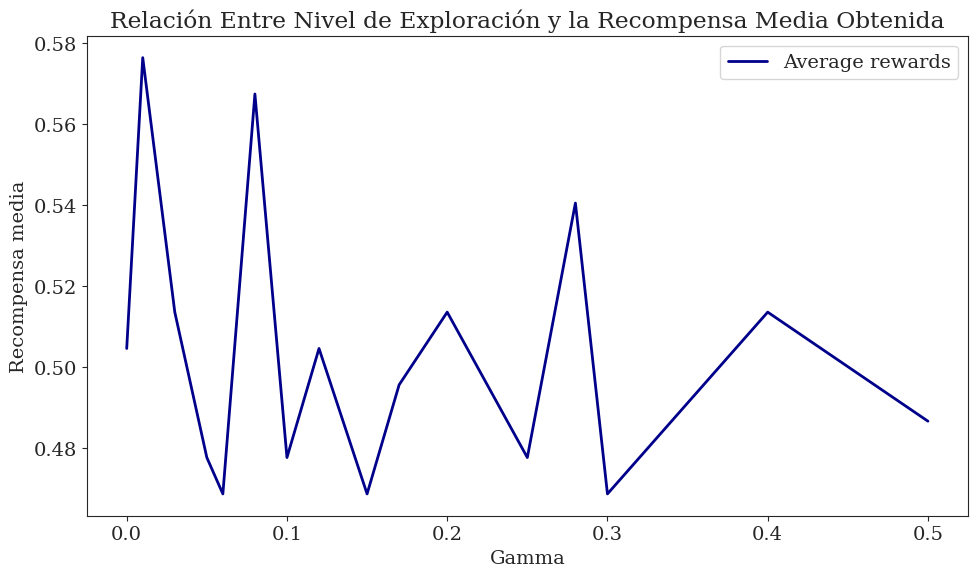

In [84]:
T = 89

symbol = 'BZ=F'
start_date = '2015-01-01'
end_date = '2023-01-01'
frecuency = '18'

# Descargar los datos
data = downloadIndicators(symbol, start_date, end_date, frecuency, T)
fechas = data.iloc[:T].index

# Determinar a que índice del array de probabilidades de elegir tomar cada desicion de los expertos
position_index = {
    Position.LONG: 0,
    Position.HOLD: 1,
    Position.SHORT: 2
}

# Guarda los expertos en una variable
experts = createExperts(len(position_index))

# SPECIFY MODE !!!! {"run", "analisis_eta", "analisis_gamma",  "analisis_horizonte_temporal"}
mode = "analisis_gamma"

switcher = {
        "run": run,
        "analisis_eta": analisis_eta,
        "analisis_gamma": analisis_gamma,
        "analisis_horizonte_temporal": analisis_horizonte_temporal,
    }

# Get the function from switcher dictionary
func = switcher.get(mode, lambda: "Invalid mode")

# Execute the function
func(T, data, fechas, position_index, experts)




